# Sistemas de recomendación

---

## Introducción

### Librerías

In [38]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar el dataset

In [5]:
# Dataset
url = "https://raw.githubusercontent.com/jorge-robledo11/Datasets/main/Datasets%20-%20ML%20Nivel%20Avanzado/retail_dataset.csv"
dataset = pd.read_csv(url, sep=",")

### Configuración inicial

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Redondeamos a 2 dígitos
pd.options.display.float_format = '{:,.2f}'.format

# Seed
seed = 1337
np.random.seed(seed)

# Copia del dataset
data = dataset.copy()

---

## Análisis de los datos

In [4]:
# Dataset
data.head()

,0,1,2,3,4,5,6
0,Bread,Wine,Eggs,Meat,Cheese,Pencil,Diaper
1,Bread,Cheese,Meat,Diaper,Wine,Milk,Pencil
2,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
3,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
4,Meat,Pencil,Wine,NaN,NaN,NaN,NaN


In [6]:
# Shape
print(f'Filas: {data.shape[0]}')
print(f'Columnas: {data.shape[1]}')

Filas: 315
Columnas: 7


In [7]:
# Data types for each predictor
print(data.dtypes)

0    object
1    object
2    object
3    object
4    object
5    object
6    object
dtype: object


In [8]:
# Missing values
print(data.isnull().sum())

0      0
1     30
2     70
3    128
4    182
5    244
6    274
dtype: int64


In [9]:
# Statistical Summary
data.describe()

,0,1,2,3,4,5,6
count,315,285,245,187,133,71,41
unique,9,9,9,9,9,9,9
top,Bread,Meat,Eggs,Milk,Wine,Pencil,Bread
freq,74,47,52,45,36,13,11


In [13]:
# Unique values
items = (data['0'].unique())
items

array(['Bread', 'Cheese', 'Meat', 'Eggs', 'Wine', 'Bagel', 'Pencil',
       'Diaper', 'Milk'], dtype=object)

---

## Preprocesamiento de datos

### One-hot Encoding

In [17]:
# One-hot encoding
encoded_vals = list()

for index, row in data.iterrows():
    labels = dict()
    uncommons = list(set(items) - set(row))
    commons = list(set(items).intersection(row))
    for uc in uncommons:
        labels[uc] = 0
    for com in commons:
        labels[com] = 1
    encoded_vals.append(labels)

In [20]:
# Casting to Dataframe
data = pd.DataFrame(encoded_vals)
data.head(10)

,Bagel,Milk,Pencil,Eggs,Diaper,Wine,Bread,Meat,Cheese
0,0,0,1,1,1,1,1,1,1
1,0,1,1,0,1,1,1,1,1
2,0,1,0,1,0,1,0,1,1
3,0,1,0,1,0,1,0,1,1
4,0,0,1,0,0,1,0,1,0
5,1,1,1,1,1,1,1,0,0
6,0,0,1,1,0,1,0,0,1
7,1,1,1,0,1,0,1,0,0
8,0,1,0,1,1,1,1,0,1
9,1,0,1,1,1,1,0,1,1


---

## Fase de modelado

### Salida básica

In [23]:
# Apriori
freq_items = apriori(data, min_support=0.2, use_colnames=True, verbose=1)
freq_items.head(10)

Processing 114 combinations | Sampling itemset size 3


,support,itemsets
0,0.43,(Bagel)
1,0.50,(Milk)
2,0.36,(Pencil)
3,0.44,(Eggs)
4,0.41,(Diaper)
5,0.44,(Wine)
6,0.50,(Bread)
7,0.48,(Meat)
8,0.50,(Cheese)
9,0.23,"(Milk, Bagel)"


### Reglas de asociación

In [24]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.6)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Bagel),(Bread),0.43,0.50,0.28,0.66,1.30,0.06,1.44
1,(Cheese),(Milk),0.50,0.50,0.30,0.61,1.21,0.05,1.27
2,(Milk),(Cheese),0.50,0.50,0.30,0.61,1.21,0.05,1.27
3,(Eggs),(Meat),0.44,0.48,0.27,0.61,1.28,0.06,1.34
4,(Eggs),(Cheese),0.44,0.50,0.30,0.68,1.36,0.08,1.56
5,(Wine),(Cheese),0.44,0.50,0.27,0.62,1.23,0.05,1.30
6,(Cheese),(Meat),0.50,0.48,0.32,0.65,1.36,0.08,1.48
7,(Meat),(Cheese),0.48,0.50,0.32,0.68,1.36,0.08,1.56
8,"(Cheese, Meat)",(Milk),0.32,0.50,0.20,0.63,1.25,0.04,1.34
9,"(Milk, Meat)",(Cheese),0.24,0.50,0.20,0.83,1.66,0.08,2.95


### Filtrar

**Pandas** facilita el filtrado de los resultados aún más. Digamos que solo estamos interesados en **reglas** que satisfagan los siguientes criterios:
 * Al menos 2 antecedentes
 * Una confianza > 0,75
 * Un puntaje de elevación > 1.2

Podríamos calcular la longitud del antecedente de la siguiente manera:

In [25]:
# Filter
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,(Bagel),(Bread),0.43,0.50,0.28,0.66,1.30,0.06,1.44,1
1,(Cheese),(Milk),0.50,0.50,0.30,0.61,1.21,0.05,1.27,1
2,(Milk),(Cheese),0.50,0.50,0.30,0.61,1.21,0.05,1.27,1
3,(Eggs),(Meat),0.44,0.48,0.27,0.61,1.28,0.06,1.34,1
4,(Eggs),(Cheese),0.44,0.50,0.30,0.68,1.36,0.08,1.56,1
5,(Wine),(Cheese),0.44,0.50,0.27,0.62,1.23,0.05,1.30,1
6,(Cheese),(Meat),0.50,0.48,0.32,0.65,1.36,0.08,1.48,1
7,(Meat),(Cheese),0.48,0.50,0.32,0.68,1.36,0.08,1.56,1
8,"(Cheese, Meat)",(Milk),0.32,0.50,0.20,0.63,1.25,0.04,1.34,2
9,"(Milk, Meat)",(Cheese),0.24,0.50,0.20,0.83,1.66,0.08,2.95,2


In [35]:
# Filter
rules[ (rules['antecedent_len'] >= 2) &
       (rules['confidence'] > 0.75) &
       (rules['lift'] > 1.2) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
9,"(Milk, Meat)",(Cheese),0.24,0.50,0.20,0.83,1.66,0.08,2.95,2
12,"(Eggs, Meat)",(Cheese),0.27,0.50,0.22,0.81,1.61,0.08,2.62,2


In [36]:
# Filter
rules[rules['antecedents'] == {'Meat', 'Milk'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
9,"(Milk, Meat)",(Cheese),0.24,0.50,0.20,0.83,1.66,0.08,2.95,2


---

## Visualización

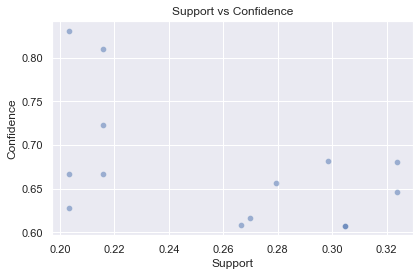

In [42]:
# Support vs Confidence
plt.title('Support vs Confidence')
sns.scatterplot(x=rules['support'], y=rules['confidence'], alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
sns.set_theme(context='notebook', style='darkgrid', palette='dark')
plt.tight_layout();

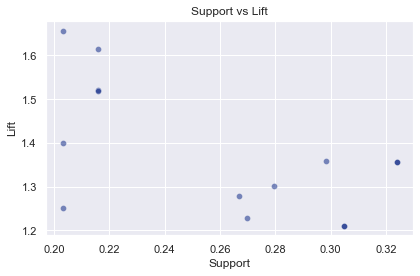

In [43]:
# Support vs Confidence
plt.title('Support vs Lift')
sns.scatterplot(x=rules['support'], y=rules['lift'], alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Lift')
sns.set_theme(context='notebook', style='darkgrid', palette='dark')
plt.tight_layout();

---